<a href="https://colab.research.google.com/github/S4b3/PITC-21-22/blob/main/classification_and_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sync Code

Clone the GitHub Repo


In [59]:
!cd /content
!git clone https://github.com/szappac20/training_camp_21_22.git -b develop

fatal: destination path 'training_camp_21_22' already exists and is not an empty directory.


`Move to the Python Project root folder` and install requirements

In [60]:
%cd /content/training_camp_21_22
%pip install --upgrade -r requirements.txt -qqq

/content/training_camp_21_22


# Download Dataset from Kaggle competition

Download dataset from Kaggle competition pitc-2122-clustering

In [61]:
!mkdir -p ~/.kaggle

Download the kaggle.json token file

In [ ]:
!gdown 1w81nWRhAr1E_hX9OSncuMxlCefxnP2zN -O  ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Downloading...
From: https://drive.google.com/uc?id=1w81nWRhAr1E_hX9OSncuMxlCefxnP2zN
To: /root/.kaggle/kaggle.json
100% 74.0/74.0 [00:00<00:00, 106kB/s]


Download the input file (training and test)

In [ ]:
!mkdir -p data/task_1

In [62]:
%cd data/task_1

/content/training_camp_21_22/data/task_1


In [ ]:
!kaggle competitions download -c pitc-2122-clustering
!unzip pitc-2122-clustering.zip

 69% 16.0M/23.1M [00:00<00:00, 167MB/s]
100% 23.1M/23.1M [00:00<00:00, 194MB/s]
Archive:  pitc-2122-clustering.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
%cd /content/training_camp_21_22

/content/training_camp_21_22


# Import packages

Move back to the Python project folder 

In [73]:
%cd /content/training_camp_21_22

/content/training_camp_21_22


Set the Python Path variable to the source folder

In [71]:
import sys
import os

sys.path.append("training_camp_21_22")

Import libraries

In [72]:
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
import csv

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
import tensorflow_decision_forests as tfdf

import training_camp_21_22.config
import training_camp_21_22.data.commercial_offer
import training_camp_21_22.models
import training_camp_21_22.view.classification

# Preprocess Data

Dowload the data

In [80]:
# Parse the csv file with json entries

def convert_json_2_pd(json_input_path, train = True):
    """
    Read the csv file and extract from json events
    any feature useful to classify the consumer consumption profile 
    """
    csv_df = pd.DataFrame(columns=[
      "userID",
      "legalNature",
      "citizenshipNoUSA",
      "billing_range.from_date",
      "billing_range.to_date",
      "fasciaF0ConsumoFatturato",
      "fasciaF1ConsumoFatturato",
      "fasciaF2ConsumoFatturato",
      "fasciaF3ConsumoFatturato",
      "fasciaF4ConsumoFatturato",
      "fasciaF5ConsumoFatturato",
      "fasciaF6ConsumoFatturato",
      "res_address_code",
      "res_address_value",
      "dom_address_code",
      "dom_address_value"
    ])


    d = {}
    labels = {}
    i = 0
    j = 0
    with open(json_input_path) as csvfile:

        reader = csv.reader(csvfile, delimiter=',')
        next(reader)

        for row in tqdm(reader):
          # iterate through bill

          for bill in json.loads(row[-1]) :
            # read consumer id
            id = row[0]

            # billing_range
            billing_range = bill['customData']['billing_range']
            energy = bill['customData']['energy']
            addresses = bill['bamData']['items']['bamItem']['addresses']
            
            res_address_code = ''
            res_address_value = ''
            dom_address_code = ''
            dom_address_value = ''

            # build the fields
            for addr in addresses:
              if(addr['type']['code'] == '2'):
                res_address_code = addr['city']['code']
                res_address_value = addr['city']['value']
              elif(addr['type']['code'] == '6'):
                dom_address_code = addr['city']['code']
                dom_address_value = addr['city']['value']
            

            d[i] = {
              'userID' : id,
              'legalNature' : bill['bamData']['items']['bamItem']['legalNature'],
              'citizenshipNoUSA' : bill['bamData']['items']['bamItem']['personInfo']['citizenshipNoUSA'],
              'billing_range.from_date' : billing_range['from_date'],
              'billing_range.to_date' : billing_range['to_date'],
              'f1' : energy['fasciaF1ConsumoFatturato'],
              'f2' : energy['fasciaF2ConsumoFatturato'],
              'f3' : energy['fasciaF3ConsumoFatturato'],
              'res_address_code': res_address_code,
              'res_address_value': res_address_value,
              'dom_address_code': dom_address_code,
              'dom_address_value': dom_address_value
            }
            i = i+1

          if(train):
            labels[j] = {'userID' : row[0] , 'cluster': int(row[1])}
            j += 1


    if(train):
      return pd.DataFrame.from_dict(d, "index"), pd.DataFrame.from_dict(labels, 'index')
    return  pd.DataFrame.from_dict(d, "index")


features_df = convert_json_2_pd(json_input_path="/content/training_camp_21_22/data/task_1/test.csv", train = False)

Let's have a look at the collected data!

In [ ]:
features_df.head()

,userID,legalNature,citizenshipNoUSA,billing_range.from_date,billing_range.to_date,f1,f2,f3,res_address_code,res_address_value,dom_address_code,dom_address_value
0,90019,PF,False,2021-11-01,2021-11-30,30.0,31.0,14.0,B794,Carmignano,B794,Carmignano
1,90019,PF,False,2021-08-01,2021-08-31,2.0,41.0,7.0,B794,Carmignano,B794,Carmignano
2,90025,PF,False,2022-02-01,2022-02-28,49.0,11.0,39.0,C422,Ceggia,C422,Ceggia
3,90025,PF,False,2021-08-01,2021-08-31,18.0,50.0,61.0,C422,Ceggia,C422,Ceggia
4,90030,PF,False,2022-06-01,2022-06-30,18.0,33.0,36.0,D170,Crispano,D170,Crispano


In [ ]:
labels_df.head()

,user,cluster
0,6,1
1,13,0
2,14,1
3,17,2
4,34,2


Load the commercial offers

In [ ]:
#Label 0
mono_oraria = training_camp_21_22.data.commercial_offer.CommercialOffer(
    price_dict={"f1": 0.28, "f2": 0.28, "f3": 0.28}, name="mono_oraria")

# Label 1
serale = training_camp_21_22.data.commercial_offer.CommercialOffer(
    price_dict={"f1": 0.31, "f2": 0.26, "f3": 0.26}, name="serale")

# Lael 2
notturna = training_camp_21_22.data.commercial_offer.CommercialOffer(
    price_dict={"f1": 0.56, "f2": 0.56, "f3": 0.}, name="notturna")

commercial_offers = [mono_oraria, serale, notturna]
class_names = [co.name for co in commercial_offers]

#Baseline Classifier

The label is computed by "extending" the mean consumptions over the whole year

In [ ]:
def project_over_year(df, commercial_offers):
    
    def best_projected_offer(row):
        columns = [co.name for co in commercial_offers]
        cluster = np.argmin(row[columns])
        return cluster
        
    year_projection = 12 * df.groupby(by=["userID"]).mean()

    for offer in commercial_offers:
        year_projection[offer.name] = year_projection.apply(
            offer.compute_yearly_cost, axis=1)

    year_projection["cluster"] = year_projection.apply(
        best_projected_offer, axis=1)
    year_projection = year_projection.drop(
        [co.name for co in commercial_offers], axis=1)

    return year_projection


year_projection_df = project_over_year(
    features_df, commercial_offers)

Let's have a look at the projection!

In [ ]:
year_projection_df.head()

,citizenshipNoUSA,f1,f2,f3,cluster
userID,,,,,
0,0.0,228.0,572.0,440.0,1
1,0.0,12.0,528.0,444.0,1
10,0.0,508.0,176.0,796.0,2
100,0.0,648.0,36.0,960.0,2
1000,0.0,396.0,654.0,102.0,1


Plotting the confusion matrix

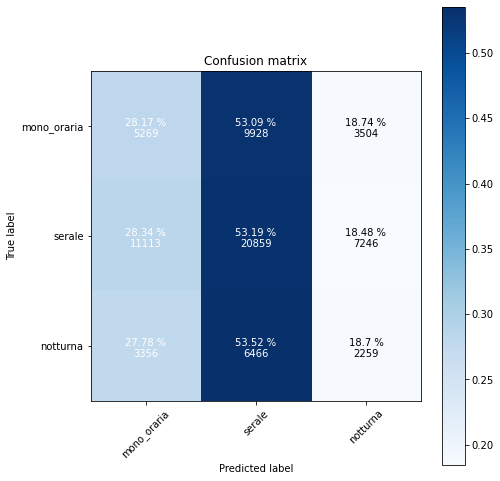

In [ ]:
cm = confusion_matrix(
    labels_df["cluster"], year_projection_df["cluster"])

# Log the confusion matrix as an image summary
figure = training_camp_21_22.view.classification.plot_cm_with_labels(
    cm, class_names=class_names);

# Random Forest Classifier

Random Forest model

In [112]:
train_df, labels_df = convert_json_2_pd(json_input_path = '/content/training_camp_21_22/data/task_1/train.csv')
test_df = convert_json_2_pd(json_input_path = '/content/training_camp_21_22/data/task_1/test.csv', train= False)

70000it [00:20, 3394.07it/s]
10000it [00:02, 3440.39it/s]


In [98]:
train_df.head()

,userID,legalNature,citizenshipNoUSA,billing_range.from_date,billing_range.to_date,f1,f2,f3,res_address_code,res_address_value,dom_address_code,dom_address_value
0,6,PF,False,2022-04-01,2022-04-30,44.0,73.0,0.0,D415,Eraclea,D415,Eraclea
1,6,PF,False,2022-02-01,2022-02-28,38.0,69.0,0.0,D415,Eraclea,D415,Eraclea
2,6,PF,False,2021-12-01,2021-12-31,49.0,68.0,0.0,D415,Eraclea,D415,Eraclea
3,6,PF,False,2021-09-01,2021-09-30,57.0,80.0,41.0,D415,Eraclea,D415,Eraclea
4,13,PF,False,2022-01-01,2022-01-31,55.0,62.0,26.0,A638,Barcellona Pozzo di Gotto,A638,Barcellona Pozzo di Gotto


In [113]:
## in order to implement a random forest classifier we need only numerical values!

ord_enc = OrdinalEncoder()

# we therefore proceed to translate the data in numerical values

train_df["legalNature"] = ord_enc.fit_transform(train_df[["legalNature"]])
train_df["citizenshipNoUSA"] = ord_enc.fit_transform(train_df[["citizenshipNoUSA"]])
train_df["billing_range.from_date"] = ord_enc.fit_transform(train_df[["billing_range.from_date"]])
train_df["billing_range.to_date"] = ord_enc.fit_transform(train_df[["billing_range.to_date"]])
train_df["res_address_code"] = ord_enc.fit_transform(train_df[["res_address_code"]])
train_df["res_address_value"] = ord_enc.fit_transform(train_df[["res_address_value"]])
train_df["dom_address_code"] = ord_enc.fit_transform(train_df[["dom_address_code"]])
train_df["dom_address_value"] = ord_enc.fit_transform(train_df[["dom_address_value"]])

# we therefore proceed to translate the data in numerical values

test_df["legalNature"] = ord_enc.fit_transform(test_df[["legalNature"]])
test_df["citizenshipNoUSA"] = ord_enc.fit_transform(test_df[["citizenshipNoUSA"]])
test_df["billing_range.from_date"] = ord_enc.fit_transform(test_df[["billing_range.from_date"]])
test_df["billing_range.to_date"] = ord_enc.fit_transform(test_df[["billing_range.to_date"]])
test_df["res_address_code"] = ord_enc.fit_transform(test_df[["res_address_code"]])
test_df["res_address_value"] = ord_enc.fit_transform(test_df[["res_address_value"]])
test_df["dom_address_code"] = ord_enc.fit_transform(test_df[["dom_address_code"]])
test_df["dom_address_value"] = ord_enc.fit_transform(test_df[["dom_address_value"]])


train_df = pd.merge(train_df, labels_df, on='userID', how='outer')
train_df.drop(columns = ["userID"])
user_ids = test_df["userID"]
test_df.drop(columns=["userID"])


,legalNature,citizenshipNoUSA,billing_range.from_date,billing_range.to_date,f1,f2,f3,res_address_code,res_address_value,dom_address_code,dom_address_value
0,0.0,0.0,4.0,4.0,30.0,31.0,14.0,808.0,796.0,569.0,574.0
1,0.0,0.0,1.0,1.0,2.0,41.0,7.0,808.0,796.0,569.0,574.0
2,0.0,0.0,7.0,7.0,49.0,11.0,39.0,1089.0,1075.0,772.0,777.0
3,0.0,0.0,1.0,1.0,18.0,50.0,61.0,1089.0,1075.0,772.0,777.0
4,0.0,0.0,11.0,11.0,18.0,33.0,36.0,1408.0,1402.0,1001.0,1010.0
...,...,...,...,...,...,...,...,...,...,...,...
25811,0.0,0.0,1.0,1.0,14.0,19.0,27.0,4207.0,4284.0,1752.0,1790.0
25812,0.0,0.0,4.0,4.0,78.0,77.0,63.0,1122.0,1111.0,795.0,802.0
25813,0.0,0.0,3.0,3.0,68.0,58.0,42.0,1122.0,1111.0,795.0,802.0
25814,0.0,0.0,1.0,1.0,47.0,33.0,1.0,3240.0,3269.0,2274.0,2307.0


In [114]:
# Convert the dataset into a TensorFlow dataset.
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="cluster")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2542: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [100]:
# Train a Random Forest model.
model = tfdf.keras.RandomForestModel()
model.fit(train_ds)

Use /tmp/tmpr98xs__1 as temporary training directory
Reading training dataset...


/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2542: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


Training dataset read in 0:00:01.376162. Found 180979 examples.
Training model...
Model trained in 0:14:50.090187
Compiling model...
Model compiled.


In [102]:
model.summary()

Model: "random_forest_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (12):
	billing_range.from_date
	billing_range.to_date
	citizenshipNoUSA
	dom_address_code
	dom_address_value
	f1
	f2
	f3
	legalNature
	res_address_code
	res_address_value
	userID

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.        "citizenshipNoUSA" 13.783641 ################
    2.             "legalNature" 13.783641 ################
    3.                 "__LABEL" 13.783641 ################
    4.   "billing_range.to_date" 12.920584 ##############
    5. "billing_range.from_date" 12.850448 ##############
    6.       "res_address_value" 11.916655 #############
    7.        "dom_address_code" 11.866435 ##########

In [126]:
predictions = {'user': user_ids.values, 'predictions': model.predict(test_ds)}


26/26 [==============================] - 5s 183ms/step


In [139]:
predictions

{'predictions': array([[0.6266662 , 0.37333307, 0.        ],
        [0.00666667, 0.9933325 , 0.        ],
        [0.71999943, 0.27333316, 0.00666667],
        ...,
        [0.9166659 , 0.08333332, 0.        ],
        [0.99999917, 0.        , 0.        ],
        [0.01666667, 0.9833325 , 0.        ]], dtype=float32),
 'user': array(['90019', '90019', '90025', ..., '99989', '99991', '99995'],
       dtype=object)}

In [130]:
outdict = dict((el,[0]) for el in predictions['user'])

print(outdict)

for index, user in enumerate(predictions['user']):
  if(max(outdict[user]) < max(predictions['predictions'][index])) :
      outdict[user] = predictions['predictions'][index]

{'90019': [0], '90025': [0], '90030': [0], '90039': [0], '90042': [0], '90046': [0], '90048': [0], '90059': [0], '90069': [0], '90072': [0], '90073': [0], '90085': [0], '90094': [0], '90105': [0], '90107': [0], '90109': [0], '90130': [0], '90136': [0], '90147': [0], '90175': [0], '90180': [0], '90189': [0], '90210': [0], '90218': [0], '90220': [0], '90228': [0], '90234': [0], '90243': [0], '90254': [0], '90267': [0], '90272': [0], '90278': [0], '90280': [0], '90296': [0], '90304': [0], '90311': [0], '90319': [0], '90328': [0], '90358': [0], '90360': [0], '90362': [0], '90367': [0], '90372': [0], '90379': [0], '90385': [0], '90388': [0], '90393': [0], '90414': [0], '90416': [0], '90430': [0], '90446': [0], '90450': [0], '90454': [0], '90457': [0], '90461': [0], '90476': [0], '90482': [0], '90485': [0], '90487': [0], '90490': [0], '90493': [0], '90501': [0], '90524': [0], '90528': [0], '90541': [0], '90550': [0], '90552': [0], '90555': [0], '90557': [0], '90563': [0], '90567': [0], '9057

In [132]:
pred_dict = dict((el, np.argmax(outdict[el])) for el in outdict.keys())

In [104]:
predictions = np.argmax(model.predict(test_ds), axis=1)

26/26 [==============================] - 5s 180ms/step


In [91]:
print(model.evaluate(test_ds, return_dict=True))

26/26 [==============================] - 5s 198ms/step - loss: 0.0000e+00
{'loss': 0.0}


# Submit solution to Kaggle competition

In [ ]:
test_submission = pd.DataFrame({
    "user": year_projection_df.index,
    "cluster": year_projection_df["cluster"]})
print(test_submission.head(10))
print(test_submission.shape)

         user  cluster
userID                
90000   90000        2
90001   90001        2
90002   90002        1
90003   90003        0
90004   90004        1
90005   90005        1
90006   90006        0
90007   90007        0
90008   90008        1
90009   90009        1
(10000, 2)


In [135]:
test_submission = pd.DataFrame({
    "user": pred_dict.keys(),
    "cluster": pred_dict.values()})
print(test_submission.head(10))
print(test_submission.shape)

    user  cluster
0  90019        1
1  90025        1
2  90030        1
3  90039        0
4  90042        2
5  90046        1
6  90048        2
7  90059        0
8  90069        1
9  90072        1
(10000, 2)


Create a termporary folder for submissions

In [136]:
!mkdir -p submissions

In [137]:
rf_labels_path = "submissions/baseline.csv"
test_submission.to_csv(rf_labels_path, index=False)

In [138]:
!kaggle competitions submit -c pitc-2122-clustering -f "submissions/baseline.csv" -m "Random Forest classification"

100% 78.1k/78.1k [00:00<00:00, 411kB/s]
Successfully submitted to PITC 21/22 - Clustering